<a href="https://colab.research.google.com/github/ishgirwan/omdena_hdi/blob/master/training_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
#!python pytorch-xla-env-setup.py --version nightly --apt-packages libomp5 libopenblas-dev

In [ ]:
!nvidia-smi 

In [ ]:
!pip install rasterio
#pip install pytorch-lightning
!pip install pytorch-lightning-bolts
#!pip install albumentations
!pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade

In [ ]:
import numpy as np
import pandas as pd
import rasterio

import torch
import torchvision
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, sampler
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pl_bolts.callbacks import PrintTableMetricsCallback
from pytorch_lightning.metrics import MeanAbsoluteError
#import albumentations as A

#from sklearn.preprocessing import MinMaxScaler    
from sklearn.metrics import r2_score

import glob
import os

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
csv_path = '/content/drive/My Drive/omdena_hdi/hdi_with_geometry.csv'
root_dir = '/content/drive/My Drive/Landsat/'

In [ ]:
model =  torchvision.models.resnet18(pretrained=False, progress=True)

In [ ]:
model.conv1 = nn.Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(3, 3), bias=False)
model.fc = nn.Sequential(nn.Linear(in_features=512, out_features=1000, bias=True), nn.Sigmoid())

In [ ]:
class MyDataset(Dataset):
    """
    Generate normalized, rescaled and transformed datasets
    """

    def __init__(self, dataset, transform=None):
        
        super().__init__()
        self.df = dataset
        self.transform = transform

    def __len__(self):
        
        return len(self.df)
    
    def __getitem__(self, idx):
       
        if torch.is_tensor(idx):
              idx = idx.tolist()

        # generate image sample
        image_path = self.df['image_path'].iloc[idx] 
        image_sample = rasterio.open(str(image_path), "r")
        bands = [i for i in range(1, image_sample.count+1)]
        image_sample = image_sample.read(bands)
        image_sample = image_sample.astype('float32')

        # generate hdi sample

        hdi_sample = self.df['HDI'].iloc[idx]

        # Normalize the image sample and rescale it between 0 and 1
        for ch in range(image_sample.shape[0]):
            channel_mean = np.nanmean(image_sample[ch])
            channel_stdev = np.nanstd(image_sample[ch])
            image_sample[ch] = (image_sample[ch] - channel_mean)

            if channel_stdev != 0:

                # standardize
                image_sample[ch] = image_sample[ch] / channel_stdev
                
                # normalize
                image_sample[ch] = (image_sample[ch] - np.nanmin(image_sample[ch])) / (np.nanmax(image_sample[ch]) - np.nanmin(image_sample[ch]))
        
        # convet nan to 0
        image_sample[np.isnan(image_sample)] = 0

        if self.transform:
            image_sample = self.transform(image_sample)

        else:
            return [image_sample.permute(1, 0, 2),  hdi_sample.astype('float32')]
    

In [ ]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor,  ModelCheckpoint

# default used by the Trainer
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    strict=False,
    verbose=True,
    mode='min')


# DEFAULTS used by the Trainer
checkpoint_callback = ModelCheckpoint(
    filepath='/content/drive/My Drive/omdena/ckpt/model.ckpt',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min',
    prefix=''
)

lr_monitor = LearningRateMonitor(logging_interval='step')


In [ ]:
def my_collate(batch):

    max_wh = 0

    for item in batch:
        image = item[0]
        w = image.shape[1]
        h = image.shape[2]
        max_i = np.max([w, h])
        if max_i > max_wh:
            max_wh = max_i
    
    #print(max_wh)

    data = []

    for item in batch:
        image = item[0]
        rows = image.shape[1]
        cols = image.shape[2]
        rows_diff = max_wh - rows
        cols_diff = max_wh - cols
        cols_half = int(cols_diff / 2)
        rows_half = int(rows_diff / 2)
        padding = (cols_half, cols_diff-cols_half, rows_half, rows_diff-rows_half)
        image_pad = F.pad(image, padding, 'constant', 0)
        #print(image.shape)
        #print(image_pad.shape)
        #print(type(image_pad))
        data.append(image_pad)

    target = [item[1] for item in batch]
    return [data, target]

In [ ]:
#df_test = pd.DataFrame(columns = ['y', 'y_hat', 'idx'])


In [ ]:

class Model(pl.LightningModule):

    def __init__(self, model, batch_size=1, learning_rate=.001):
        super().__init__()
        self.learning_rate = learning_rate
        self.save_hyperparameters()
        self.model = model
        self.batch_size = batch_size
        self.ser_y = pd.Series(dtype='float32', name='y')
        self.ser_y_hat = pd.Series(dtype='float32', name='y_pred')

    def forward(self, x):
        x = self.model(x)
        #print('shape', x.shape)
        x = torch.mean(x, 1)
        return x

    def prepare_data(self):

        df = pd.read_csv(csv_path)
        df['image_path'] = root_dir + df['unique code'].astype(str) + '.tif' 
        df = df.sample(frac=1, random_state=1).reset_index(drop=True)
        # split the dataset
        train, validate, test = np.split(df, [int(.9*len(df)), int(.95*len(df))]) 

        # transforms
        train_transform = transforms.Compose([
                                transforms.ToTensor()
                                ])

        validate_transform = transforms.Compose([
                                transforms.ToTensor()
                                ])
        # create datasets for training, validation and test
        self.train_dataset = MyDataset(dataset=train, transform=train_transform)
        self.validate_dataset = MyDataset(dataset=validate, transform=validate_transform)
        self.test_dataset = MyDataset(dataset=test, transform=validate_transform) 

        return test
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, self.batch_size, shuffle=True, num_workers=4, collate_fn=my_collate, pin_memory=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.validate_dataset, self.batch_size, num_workers=4,collate_fn=my_collate, pin_memory=True, drop_last=True) 

    def test_dataloader(self):
        return DataLoader(self.test_dataset, self.batch_size, num_workers=4, collate_fn=my_collate, pin_memory=True, drop_last=True) 

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor': 'val_loss'}

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = torch.stack(x)
        y = torch.cuda.FloatTensor(y)
        y_hat = self(x)
        #print(y, y_hat)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    #def training_step_end(self, training_step_outputs):
    #    return training_step_outputs

    #def training_epoch_end(self, outputs) -> None:
    #    torch.stack([x["loss"] for x in outputs]).mean()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = torch.stack(x)
        y = torch.cuda.FloatTensor(y)
        y_hat = self(x)
        #print(y, y_hat)
        loss = F.mse_loss(y_hat, y)
        r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
        self.log('val_loss', loss)
        self.log('val_R-square', r2)
        #return {"loss": loss, 'R-square': r2_score}

    #def validation_epoch_end(self, outputs) -> None:
    #    torch.stack([x['loss'] for x in outputs]).mean()
    #    torch.stack([x['R-square'] for x in outputs]).mean()

    #def validation_epoch_end(self, outputs):
    #   avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
    #  return {'val_loss': avg_loss}

    def test_step(self, batch, batch_idx):
        x, y = batch

        y_series = pd.Series(y)
        
        x = torch.stack(x)
        y = torch.cuda.FloatTensor(y)
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        r2 = r2_score(y.cpu().detach().numpy(), y_hat.cpu().detach().numpy())
        
        self.log('test_loss', loss)
        self.log('test_R-square', r2)

        y_hat = y_hat.cpu().detach().numpy()
        y_hat_series = pd.Series(y_hat)
        #print('y_series', y_series)

        self.ser_y = self.ser_y.append(y_series, ignore_index=True)
        self.ser_y_hat = self.ser_y_hat.append(y_hat_series, ignore_index=True)

        #print('y', y)
        #print('y_hat', y_hat)
    

    def backward(self, loss, optimizer, optimizer_idx):
        loss.backward()

    def optimizer_step(self, current_epoch, batch_idx, optimizer, 
      optimizer_idx, second_order_closure=None, 
       on_tpu=False, using_native_amp=False, using_lbfgs=False):
        optimizer.step()


In [ ]:
# init model
model_one = Model(model, batch_size=16)
#from pytorch_lightning.core.memory import ModelSummary
#ModelSummary(model_one, mode='full')
from pytorch_lightning.loggers import TensorBoardLogger
logger = TensorBoardLogger('/content/drive/My Drive/omdena/tb_logs', name='my_model')

#train
root_path = '/content/drive/My Drive/omdena'

In [ ]:
#seed
resume_ckpt_path =  '/content/drive/My Drive/omdena/ckpt/model_t3.ckpt'
#resume_from_checkpoint=resume_ckpt_path,
pl.seed_everything(1)

trainer = pl.Trainer(gpus=1,resume_from_checkpoint=resume_ckpt_path, logger=logger, checkpoint_callback=checkpoint_callback, progress_bar_refresh_rate=50, accumulate_grad_batches=2, fast_dev_run=False,\
                    default_root_dir=root_path, auto_lr_find=True,\
                    profiler=True, max_epochs=1000, callbacks=[lr_monitor, early_stop, PrintTableMetricsCallback()])




GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [ ]:
trainer.fit(model_one)

In [ ]:
#!nvidia-smi 

In [ ]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir='/content/drive/My Drive/omdena/tb_logs'

In [ ]:
# test
trainer.test(ckpt_path='/content/drive/My Drive/omdena/ckpt/model.ckpt-v0.ckpt', model=model_one, verbose=True)

In [ ]:
df_pred = pd.concat([model_one.ser_y, model_one.ser_y_hat], axis=1)

In [ ]:
df_pred = df_pred.set_axis(['y', 'y_pred'], axis=1, inplace=False)

In [ ]:
df_pred['diff'] = (df_pred.y - df_pred.y_pred).abs()

In [ ]:
df_pred

,y,y_pred,diff
0,0.53461,0.398532,0.136078
1,0.49756,0.425046,0.072514
2,0.46562,0.411119,0.054501
3,0.41685,0.431976,0.015126
4,0.44367,0.350882,0.092788
...,...,...,...
939,0.45258,0.405481,0.047099
940,0.39688,0.376790,0.020090
941,0.28733,0.406607,0.119277
942,0.26788,0.398719,0.130839


In [ ]:
df = pd.read_csv(csv_path)
df['image_path'] = root_dir + df['unique code'].astype(str) + '.tif' 
df = df.sample(frac=1, random_state=1).reset_index(drop=True)
# split the dataset
train, validate, test = np.split(df, [int(.9*len(df)), int(.95*len(df))]) 

In [ ]:
test.head(10)

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry,image_path
18034,0.53461,davanagere,davanagere,nerlegi,nerlige,2956705512606632,7617.474684,3.535501e+06,"POLYGON ((614129.5213450005 1589446.426938, 61...",/content/drive/My Drive/Landsat/29567055126066...
18035,0.49756,mysuru,krishnarajanagara,chikkahanasoge,channamgere,2957705571618603,11927.509204,3.103637e+06,"POLYGON ((626997.4277450005 1385629.627738, 62...",/content/drive/My Drive/Landsat/29577055716186...
18036,0.46562,uttarakannada,kumta,santagal,santeguli,2956305485603517,7290.090149,2.779026e+06,"POLYGON ((449914.2168450005 1594854.645838, 45...",/content/drive/My Drive/Landsat/29563054856035...
18037,0.41685,kolar,srinivaspur,thimmasandra,hodali,2958105590621594,9500.702794,3.962890e+06,"POLYGON ((852212.7420450004 1481146.898838, 85...",/content/drive/My Drive/Landsat/29581055906215...
18038,0.44367,ballari,siruguppa,udegolam,nadavi,2956505499604779,12948.404795,8.151924e+06,"POLYGON ((697813.5895450005 1717591.231738, 69...",/content/drive/My Drive/Landsat/29565054996047...
18039,0.16672,hassan,channarayapatna,rayasamudrakaval,nuggehalli,2957405560617256,16527.637814,1.152461e+07,"POLYGON ((657386.1887450004 1444829.206538, 65...",/content/drive/My Drive/Landsat/29574055606172...
18040,0.36098,hassan,arsikere,bisalehalli,mududi,2957405555615785,6582.155698,2.399416e+06,"POLYGON ((641024.8853450004 1459835.998438, 64...",/content/drive/My Drive/Landsat/29574055556157...
18041,0.20949,yadgir,shorapur,gogaddihal,mallab.,2958005587620884,4835.350211,1.386170e+06,"POLYGON ((667944.5764450005 1846935.917438, 66...",/content/drive/My Drive/Landsat/29580055876208...
18042,0.48155,chikkamagaluru,kadur,m.mallenahalli,s.madapura,2957005529609604,5708.030068,1.577087e+06,"POLYGON ((633077.8166450004 1491071.388038, 63...",/content/drive/My Drive/Landsat/29570055296096...
18043,0.40064,belagavi,raybag,bhendwad,bendwad,2955505435597379,20783.642101,1.402840e+07,"POLYGON ((481465.4435450005 1809779.726038, 48...",/content/drive/My Drive/Landsat/29555054355973...


In [ ]:
test.reset_index(inplace=True, drop=True)

In [ ]:
df_final = pd.concat([test, df_pred], axis =1)

In [ ]:
df_final = df_final[df_final['y_pred'].notna()]

In [ ]:
df_final.sort_values(by=['diff'], ascending=False, inplace=True)

In [ ]:
df_final['num_pixel'] = df['SHAPE_Area'] / 900

In [ ]:
df_final.reset_index(inplace=True, drop=True)

In [ ]:
df_final.head()

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry,image_path,y,y_pred,diff,num_pixel
0,0.04171,shivamogga,sorab,balekoppa,tatturu,2956805516607494,6860.800144,1.549959e+06,"POLYGON ((518810.7192450005 1601411.493338, 51...",/content/drive/My Drive/Landsat/29568055166074...,0.04171,0.406278,0.364568,8229.346581
1,0.06456,shivamogga,shivamogga,belagalu,umblebilu,2956805520608510,5543.765565,1.366471e+06,"POLYGON ((554791.4985450004 1522096.741938, 55...",/content/drive/My Drive/Landsat/29568055206085...,0.06456,0.406033,0.341473,2676.090773
2,0.06803,uttarakannada,mundgod,veerapur,malagi,2956305482603089,8265.657717,1.955045e+06,"POLYGON ((502722.1408450005 1628068.265438, 50...",/content/drive/My Drive/Landsat/29563054826030...,0.06803,0.408183,0.340153,4932.253401
3,0.12873,chamarajanagara,gundlupet,berambadistateforest,berambadi,2957805576619556,96341.233422,2.444253e+08,"POLYGON ((667155.7107450005 1312881.293138, 66...",/content/drive/My Drive/Landsat/29578055766195...,0.12873,0.465751,0.337021,9816.910804
4,0.04304,uttarakannada,supa,kuveshi,bazaarkulang,2956305479602664,19384.635546,1.990181e+07,"POLYGON ((430512.5735450005 1695187.951038, 43...",/content/drive/My Drive/Landsat/29563054796026...,0.04304,0.379121,0.336081,65053.310785


In [ ]:
df_final.tail()

,HDI,District Name(in English),Sub District Name(in English),Village Name(in English),Local Body Name(in English),unique code,SHAPE_Leng,SHAPE_Area,geometry,image_path,y,y_pred,diff,num_pixel
939,0.38761,tumakuru,madhugiri,doddagalihalli,gondihalli,2957105535610952,6254.107260,2.126059e+06,"POLYGON ((748644.9707450005 1517008.206538, 74...",/content/drive/My Drive/Landsat/29571055356109...,0.38761,0.387060,0.000550,12400.113252
940,0.39145,koppal,koppal,kunikera,kunikeri,2956005467601777,16055.875991,1.487641e+07,"POLYGON ((632291.6446450005 1692127.216138, 63...",/content/drive/My Drive/Landsat/29560054676017...,0.39145,0.391043,0.000407,17356.279634
941,0.43359,kolar,mulbagal,batrahalli,alangur,2958105594623003,6762.333237,2.501581e+06,"POLYGON ((875571.7962450004 1460552.904638, 87...",/content/drive/My Drive/Landsat/29581055946230...,0.43359,0.433959,0.000369,2273.417774
942,0.39137,mandya,krishnarajpet,mandalekanahalli,aikanahalli,2957305546613373,5072.338958,1.393061e+06,"POLYGON ((653321.5132450005 1416443.780838, 65...",/content/drive/My Drive/Landsat/29573055466133...,0.39137,0.391713,0.000343,65720.181522
943,0.40898,chikkamagaluru,mudigere,kademadkal,hesagal,2957005531609962,8876.245382,3.546379e+06,"POLYGON ((574404.3907450004 1455273.171438, 57...",/content/drive/My Drive/Landsat/29570055316099...,0.40898,0.408671,0.000309,27244.221174


In [ ]:
df_final.to_csv('/content/drive/My Drive/post_training_analysis.csv')

In [ ]:
df_final = pd.read_csv('/content/drive/My Drive/post_training_analysis.csv')

In [ ]:
df_final.describe()

,Unnamed: 0,HDI,unique code,SHAPE_Leng,SHAPE_Area,y,y_pred,diff,num_pixel
count,944.000000,944.000000,9.440000e+02,944.000000,9.440000e+02,944.000000,944.000000,944.000000,944.000000
mean,471.500000,0.405577,2.957085e+15,10965.039557,6.500187e+06,0.405577,0.407065,0.080659,6065.306622
std,272.653626,0.106423,8.291601e+11,6489.741222,1.061206e+07,0.106423,0.028678,0.063919,6436.651366
min,0.000000,0.041710,2.955505e+15,633.375529,8.364195e+03,0.041710,0.308994,0.000309,5.488597
25%,235.750000,0.343125,2.956506e+15,6654.596334,2.024476e+06,0.343125,0.392455,0.032531,2228.728632
50%,471.500000,0.421820,2.957106e+15,9465.749559,3.955927e+06,0.421820,0.405249,0.067347,4031.143602
75%,707.250000,0.480535,2.957706e+15,13754.356337,7.520856e+06,0.480535,0.419748,0.114160,7710.371549
max,943.000000,0.653830,2.958406e+15,96341.233423,2.444253e+08,0.653830,0.475150,0.364568,65720.181522


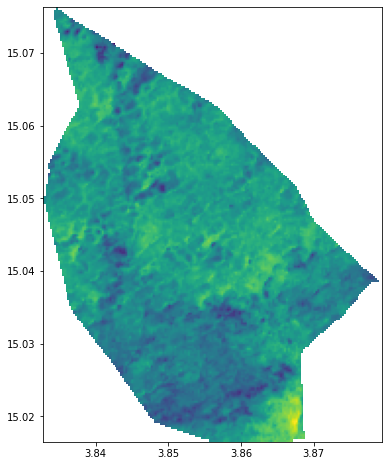

In [ ]:
import matplotlib.pyplot as plt
from rasterio.plot import show

plt.figure(figsize=(10,8))
# the file has been downloaded from drive to show here
image_h = rasterio.open(df_final['image_path'].iloc[4])
show(image_h, adjust='linear')
plt.show()

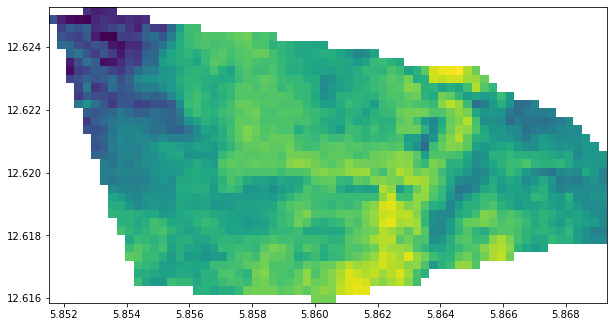

In [ ]:
plt.figure(figsize=(10,8))
# the file has been downloaded from drive to show here
image = rasterio.open(df_final['image_path'].iloc[-2])
show(image, adjust='linear')
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


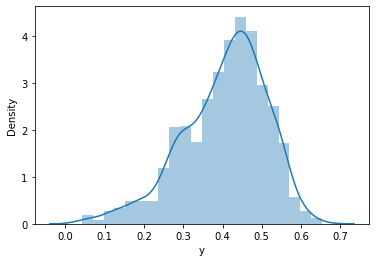

In [ ]:
sns.distplot(df_final['y'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


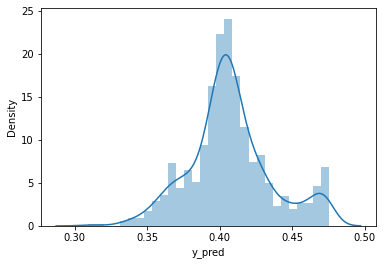

In [ ]:
sns.distplot(df_final['y_pred']);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


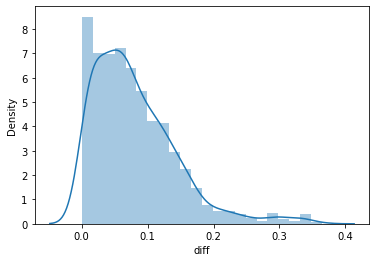

In [ ]:
sns.distplot(df_final['diff'])

In [ ]:
df_corr = df_final.corr()# irrelevant fields
fields = ['unique code', 'HDI']# drop rows
df_corr.drop(fields, inplace=True)# drop cols
df_corr.drop(fields, axis=1, inplace=True)
df_corr

,SHAPE_Leng,SHAPE_Area,y,y_pred,diff,num_pixel
SHAPE_Leng,1.000000,0.865466,0.001102,0.016692,-0.018077,-0.024448
SHAPE_Area,0.865466,1.000000,-0.080723,-0.040392,0.041211,0.002701
y,0.001102,-0.080723,1.000000,0.254271,-0.361068,-0.019093
y_pred,0.016692,-0.040392,0.254271,1.000000,0.044505,-0.001470
diff,-0.018077,0.041211,-0.361068,0.044505,1.000000,0.002876
num_pixel,-0.024448,0.002701,-0.019093,-0.001470,0.002876,1.000000
